In [16]:
library(tidyverse) 
library(ggExtra)
library(ggthemes)
library(forecast)
library(ggfortify)

In [20]:
uk <- read_table("../data.txt", col_types = "if")
period <- seq(as.Date('1969-01-01'), as.Date('1984-12-31'), by = "month")
uk_ts <- ts(uk$death, start = c(1969,1), frequency = 12)
uk_df <- bind_cols(uk, t = period)

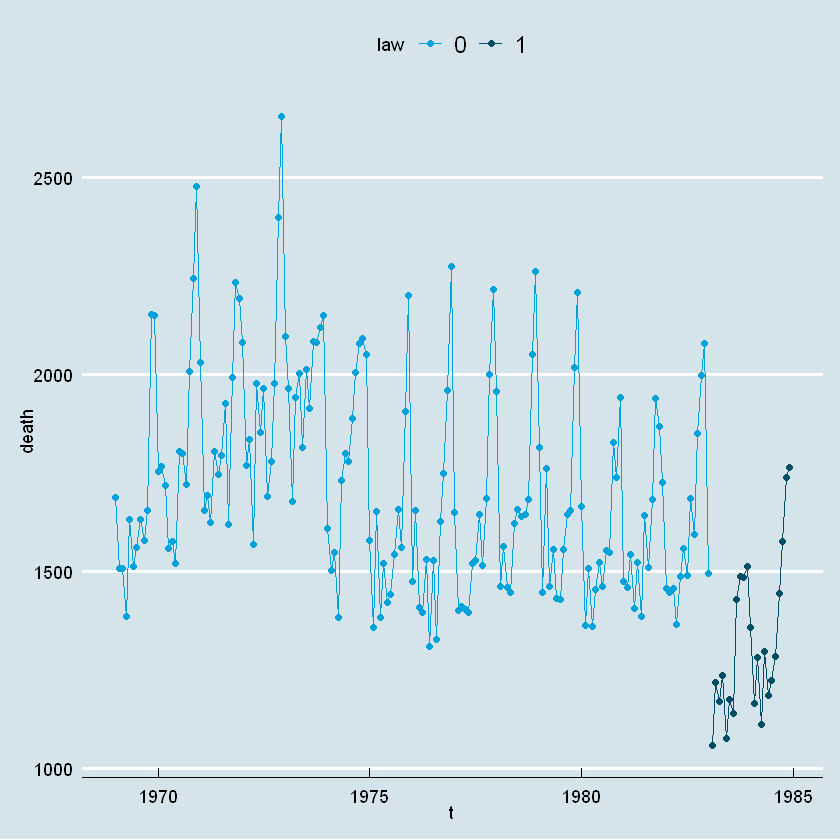

In [13]:
ggplot(uk_df) + aes(t, death, color = law) +
geom_line() + geom_point() +
theme_economist() + scale_color_economist()

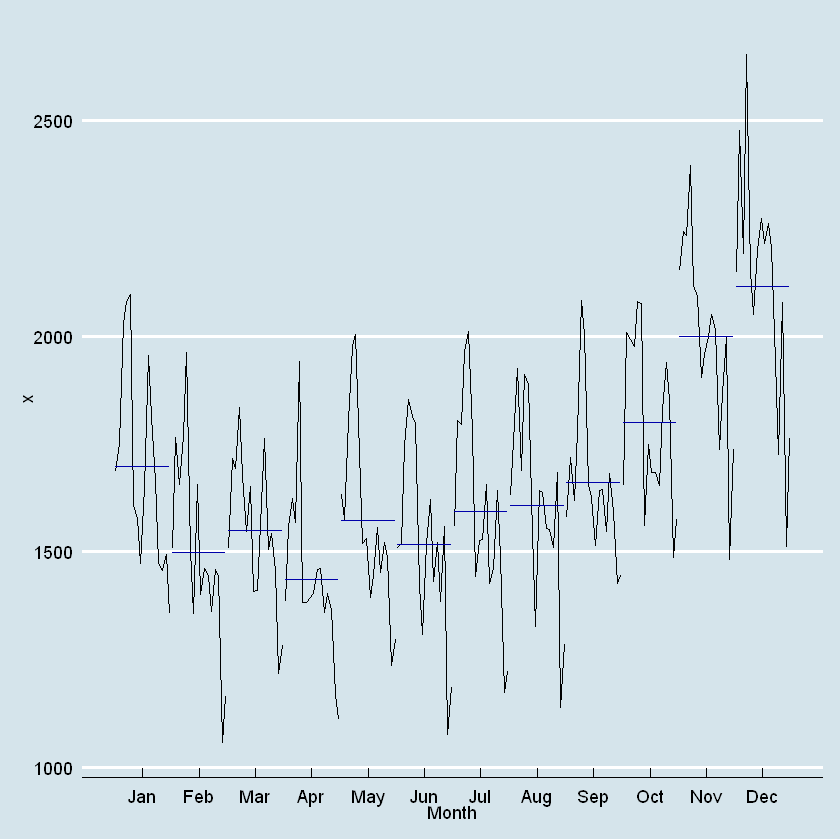

In [24]:
ggmonthplot(uk_ts) +
theme_economist() +
scale_color_economist()

In [61]:
season <- (uk_ts - ma(uk_ts, order = 12)) %>% 
matrix(12) %>% t() %>% colMeans(na.rm = T)

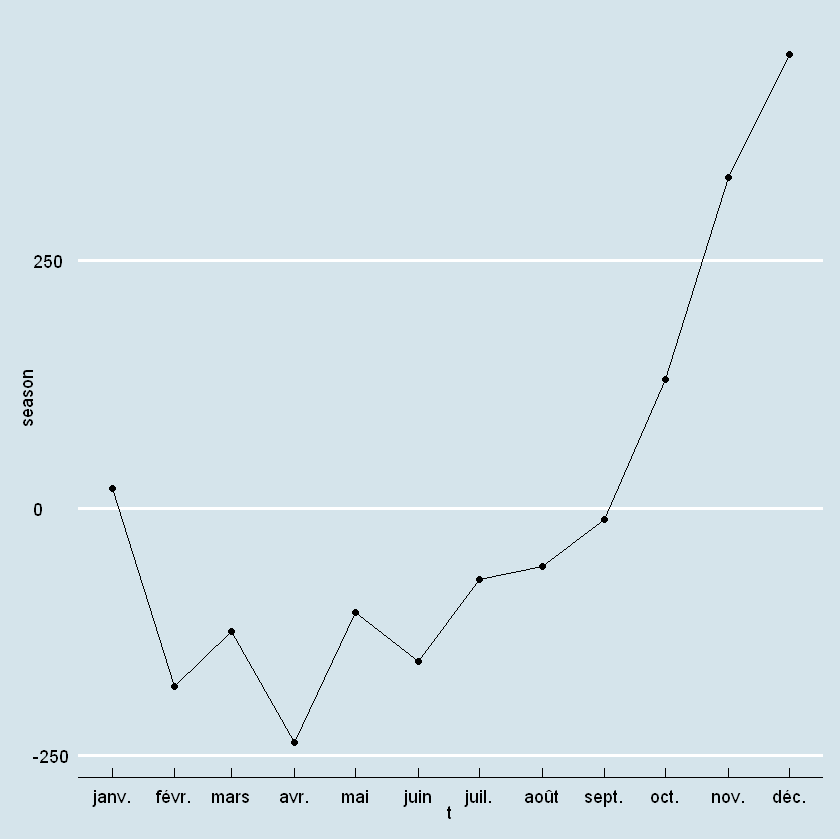

In [79]:
t = seq(as.Date('1969-01-01'), length.out = 12, by = 'month')
tibble(season, t) %>% 
ggplot() + aes(t, season) + 
geom_line() + geom_point() + 
theme_economist() +
scale_x_date(date_labels = "%b", breaks = t)

In [80]:
uk_seasonal <- (uk_ts - ma(uk_ts, order = 12)) %>% 
matrix(12) %>% t() %>% 
colMeans(na.rm = T) %>% 
rep(length(uk_ts)/12)

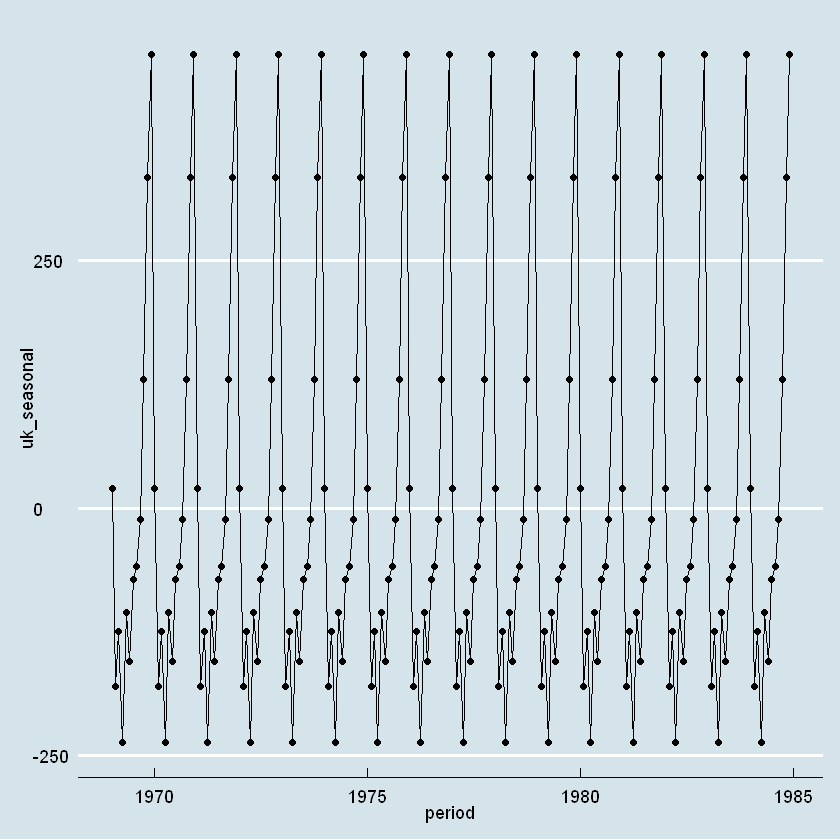

In [81]:
tibble(uk_seasonal, period) %>% 
ggplot() + aes(period, uk_seasonal) + 
geom_line() + geom_point() + 
theme_economist()

In [101]:
des <- uk_ts - uk_seasonal

In [217]:
t <- 1:length(des)
sinusoides <- t%o%c(rep(1:6,2))*pi/6
sinusoides[,1:5] <- sin(sinusoides[,1:5])
sinusoides[,6:10] <- cos(sinusoides[,6:10])
sinusoides <- as_tibble(sinusoides)
names(sinusoides) <- c(paste("sin",1:6),paste("cos",1:6))

In [237]:
df <- bind_cols(ln_death = log(uk_df$death), law = uk_df$law,tibble(t, t^2, t^3, t^4, t^5, t^6, t^7, t^8, t^9, t^10), sinusoides)

In [238]:
mod0 <- lm(ln_death~., data = df)

In [240]:
mod1 <- step(mod0, direction = "both", trace = F)

In [242]:
summary(mod1)


Call:
lm(formula = ln_death ~ law + t + `t^4` + `t^5` + `t^6` + `t^7` + 
    `t^8` + `t^9` + `t^10` + `sin 1` + `sin 2` + `sin 3` + `sin 4` + 
    `sin 5` + `sin 6` + `cos 1` + `cos 2` + `cos 3` + `cos 4`, 
    data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.173469 -0.045080 -0.001726  0.043941  0.158448 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.394e+00  2.964e-02 249.452  < 2e-16 ***
law1        -2.826e-01  5.122e-02  -5.517 1.25e-07 ***
t            3.612e-03  2.112e-03   1.710 0.089063 .  
`t^4`        3.642e-07  1.436e-07   2.536 0.012098 *  
`t^5`       -1.876e-08  6.032e-09  -3.110 0.002191 ** 
`t^6`        3.749e-10  1.087e-10   3.449 0.000707 ***
`t^7`       -3.828e-12  1.052e-12  -3.640 0.000361 ***
`t^8`        2.132e-14  5.708e-15   3.735 0.000255 ***
`t^9`       -6.179e-17  1.640e-17  -3.768 0.000226 ***
`t^10`       7.312e-20  1.944e-20   3.760 0.000232 ***
`sin 1`     -6.811e-02  7.386e-03  -9.221  

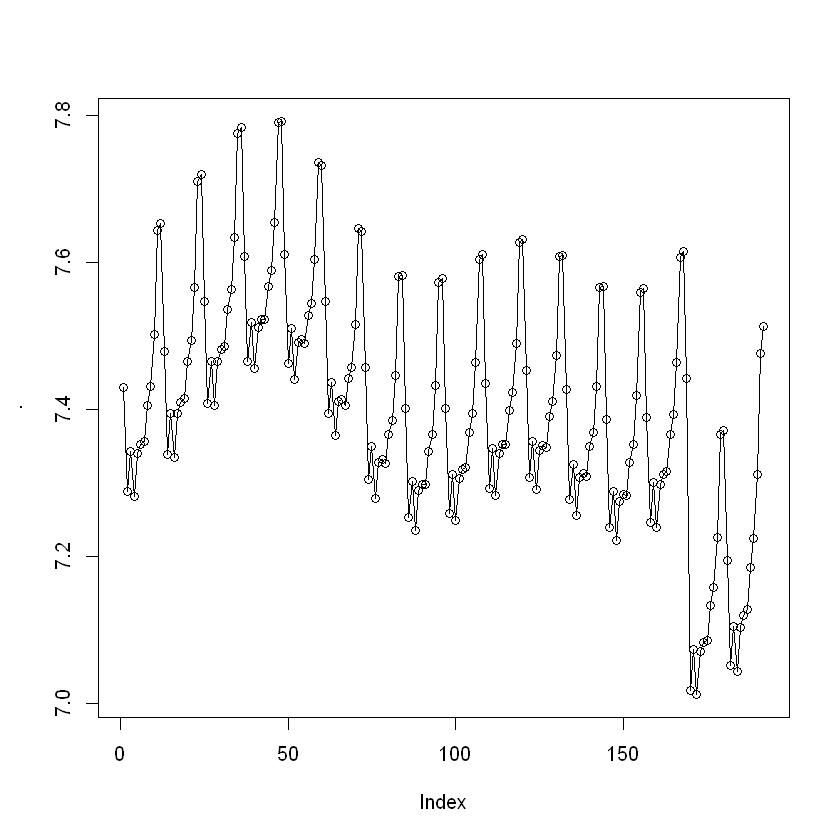

In [241]:
mod1$fitted.values %>% plot(type = "o")

# fit on trend


Call:
lm(formula = exp(ln_death) ~ t + `t^2` + `t^3` + `t^6` + `t^4`, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-391.09 -185.11  -43.46  120.10  768.89 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.344e+03  1.067e+02  12.589  < 2e-16 ***
t            4.822e+01  1.042e+01   4.627 6.93e-06 ***
`t^2`       -1.273e+00  3.069e-01  -4.147 5.12e-05 ***
`t^3`        1.276e-02  3.531e-03   3.613 0.000389 ***
`t^6`        2.523e-10  9.665e-11   2.610 0.009789 ** 
`t^4`       -4.798e-05  1.496e-05  -3.207 0.001579 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 242.7 on 186 degrees of freedom
Multiple R-squared:  0.316,	Adjusted R-squared:  0.2976 
F-statistic: 17.18 on 5 and 186 DF,  p-value: 5.818e-14


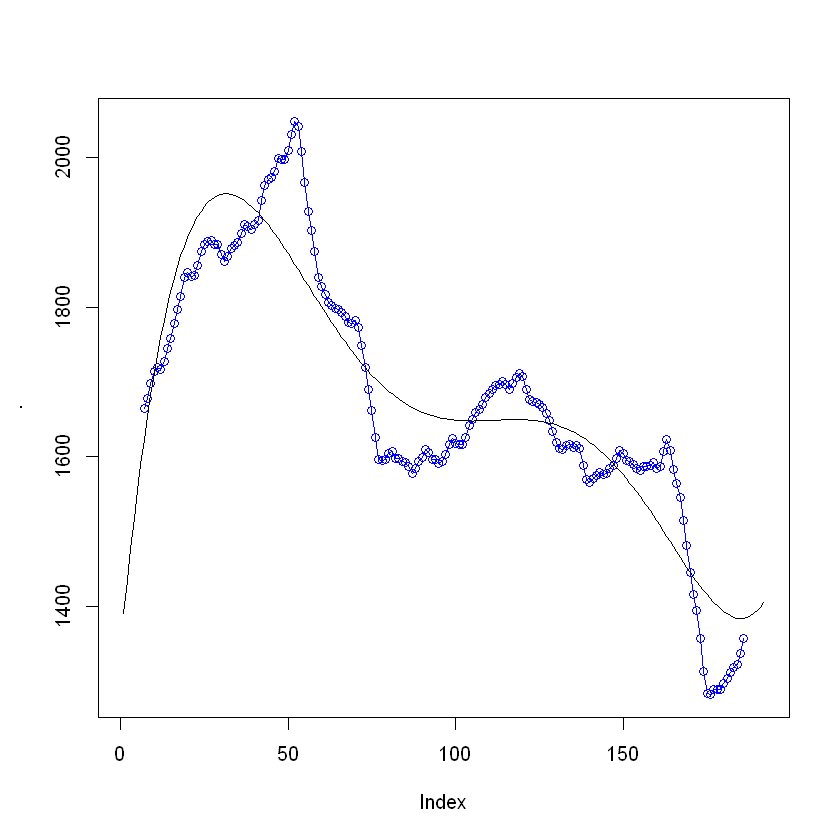

In [375]:
mod_trend <- lm(exp(ln_death) ~ t + `t^2` + `t^3`+ `t^6` + `t^4`, data = df)
summary(mod_trend)
ma(uk_ts, order = 12) %>% c()  %>% plot(type = "o", col = "blue")
mod_trend$fitted.values %>% lines()

In [325]:
library(caret)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [335]:
m_t1 <- train(ln_death~., data = na.omit(df2), method = 'lm')

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [336]:
m_t1$finalModel %>% summary()


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.038057 -0.008677 -0.000155  0.009497  0.045163 

Coefficients: (2 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.097e+00  8.343e-02  85.072  < 2e-16 ***
law           -6.762e-02  1.349e-02  -5.011 1.43e-06 ***
t              6.983e-02  1.953e-02   3.575 0.000465 ***
`\\`t^2\\``   -4.933e-03  1.743e-03  -2.831 0.005248 ** 
`\\`t^3\\``    1.733e-04  8.023e-05   2.160 0.032241 *  
`\\`t^4\\``   -2.824e-06  2.163e-06  -1.306 0.193577    
`\\`t^5\\``    1.059e-08  3.636e-08   0.291 0.771150    
`\\`t^6\\``    3.081e-10  3.922e-10   0.786 0.433270    
`\\`t^7\\``   -5.009e-12  2.711e-12  -1.847 0.066554 .  
`\\`t^8\\``    3.306e-14  1.161e-14   2.848 0.004992 ** 
`\\`t^9\\``   -1.055e-16  2.803e-17  -3.763 0.000236 ***
`\\`t^10\\``   1.337e-19  2.915e-20   4.587 9.10e-06 ***
`\\`sin 1\\``  9.568e-04  1.712e-03   0.559

# Manuelle

In [207]:
linear_fit <- lm(uk_ts ~ time(uk_ts) + uk_df$law)

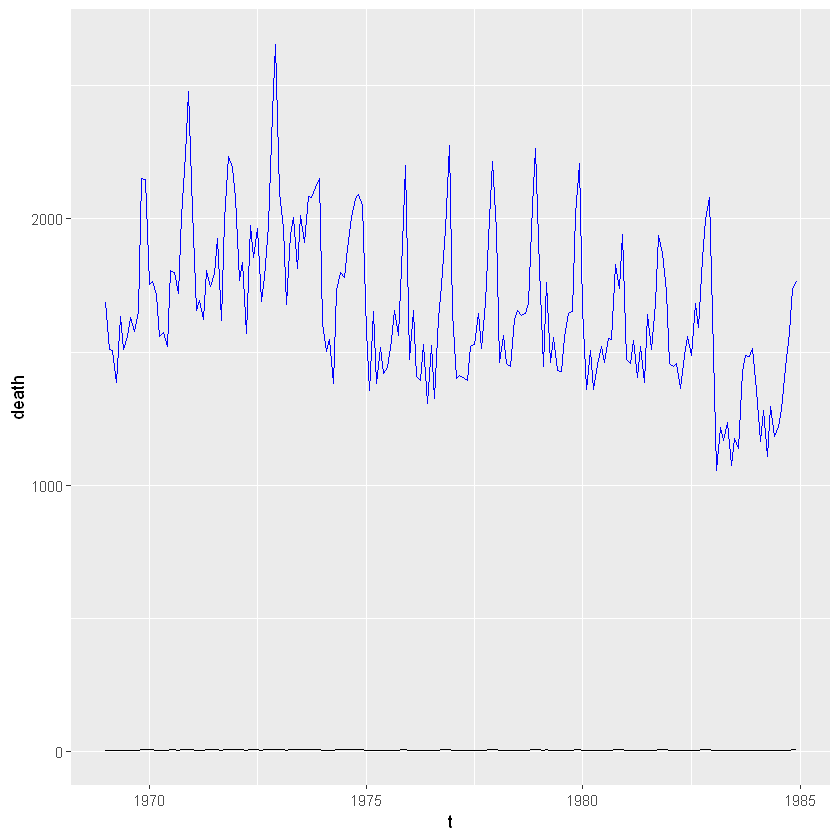

In [210]:
ggplot(uk_df) + aes(t, death) + geom_line(color = "blue") + geom_line(aes(y = log(death)))

In [198]:
filter(uk_ts, rep(1/12, 12), method = "convolution", sides = 2) 

ERROR: Error: `.data` must be a data source, not a ts object, do you want `stats::filter()`?


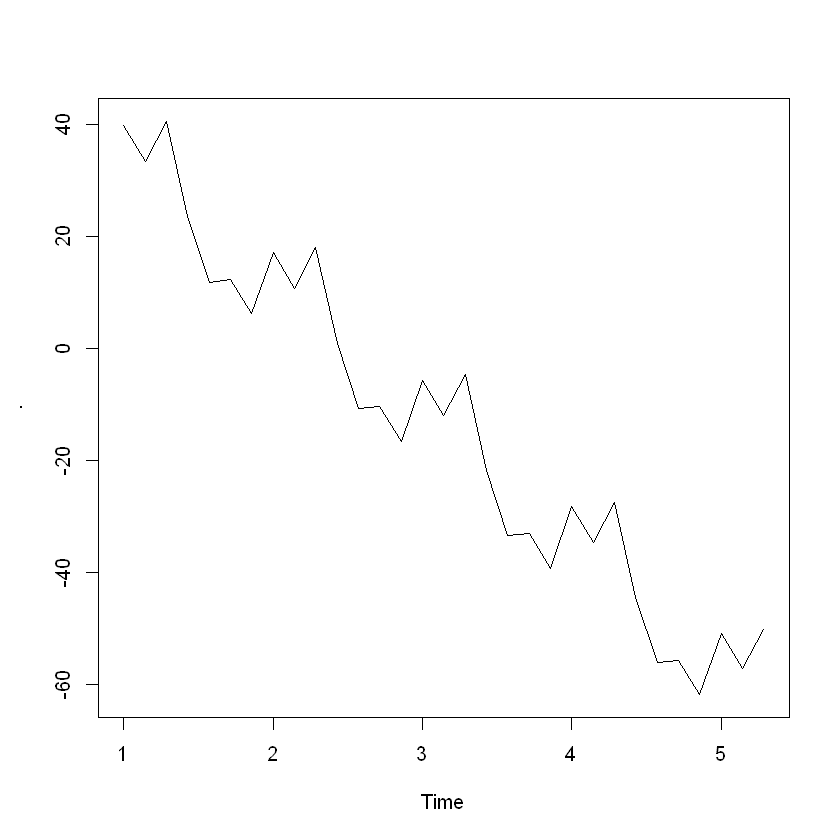

In [203]:
demand %>% plot()

In [201]:
demand <- ts(
  c(39.8, 33.5, 40.6, 23.6, 11.9, 12.3, 6.2, 17.1, 10.8, 18, 1, -10.7, 
-10.4, -16.5, -5.6, -11.9, -4.7, -21.7, -33.4, -33.1, -39.2, -28.2, 
-34.6, -27.4, -44.4, -56.1, -55.7, -61.8, -50.9, -57.2, -50.1),
frequency = 7
)

dd <- demand.values

filter(demand, rep(1/7, 7), method = "convolution", sides = 2) 

ERROR: Error in eval(expr, envir, enclos): objet 'demand.values' introuvable
